# Mock Code


In [89]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             confusion_matrix, plot_confusion_matrix,
                             precision_recall_curve, roc_curve,
                             plot_precision_recall_curve, plot_roc_curve)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


In [62]:
import io
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['hockey-data.csv']))
df.head()

Saving hockey-data.csv to hockey-data (3).csv


,Year,Rk,Player,Age,Tm,Pos,GP,G,A,PTS,...,SH.1,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%
0,2018-2019,1,Alex Ovechkin\ovechal01,33,WSH,LW,81,51,38,89,...,0,338,15.1,1695,20:55,41.0,223.0,1.0,4.0,20.0
1,2018-2019,2,Leon Draisaitl\draisle01,23,EDM,C,82,50,55,105,...,0,231,21.6,1852,22:35,26.0,57.0,677.0,663.0,50.5
2,2018-2019,3,John Tavares\tavarjo01,28,TOR,C,82,47,41,88,...,0,286,16.4,1565,19:05,53.0,59.0,833.0,694.0,54.6
3,2018-2019,4,Steven Stamkos\stamkst01,28,TBL,C,82,45,53,98,...,0,234,19.2,1501,18:18,40.0,72.0,506.0,447.0,53.1
4,2018-2019,5,Patrick Kane\kanepa01,30,CHI,RW,81,44,66,110,...,0,341,12.9,1822,22:29,18.0,21.0,1.0,4.0,20.0


In [63]:
# Transform features

# We care about predicting goals, but need to standardize 
# G = goals, TOI = total time on ice in minutes for the season 
# Divide to get goals scored per minute on ice
df['GoalsPerMinute'] = df['G'] / df['TOI']

# This is very small - multiply by 60 to find goals scored 
# per 60 minutes (length of a game)
df['GoalsPer60'] = df['GoalsPerMinute'] * 60

# One other thing that we have to do is replace NA values in 
# FO% and HIT with 0s. This will be important for fitting our 
# linear regression model later. 
df['FO%'] = df['FO%'].fillna(0)
df['HIT'] = df['HIT'].fillna(0)
# Let's start building our first linear regression model. To do this, 
# we will create X and Y data frames to hold our predictor variables 
# and response variable, respectively. 

y = df['GoalsPer60'] 
# Our first regression will be based on 4 of the variables from our 
# proposal: Assists, Age, Hits, and FO (binary faceoffs variable). We will 
# exclude Average Time on Ice because we have completely accounted 
# for this by standardizing to GoalsPer60.
X = df[['A', 'Age', 'HIT', 'FO%']]

y.head()
X.head()

,A,Age,HIT,FO%
0,38,33,223.0,20.0
1,55,23,57.0,50.5
2,41,28,59.0,54.6
3,53,28,72.0,53.1
4,66,30,21.0,20.0


In [64]:
# Now, we'll scale our data and get ready for our train-test split
# Scale data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# Set a seed for reproducible results
np.random.seed(403)

# Split data into training and test sets
(X_train, X_test,
 y_train, y_test) = train_test_split(X_scale, y, test_size=0.20)
# Fitting the model to the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_scale)
# How does the model perform on the training data? 
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')



MSE:  0.217
RMSE: 0.466
R^2:  0.171


In [65]:
# How does the model perform on the testing data?
# Set a seed for reproducible results
np.random.seed(403)

# Fit the model on the testing data
lin_reg = LinearRegression()
lin_reg.fit(X_test, y_test)

y_pred = lin_reg.predict(X_scale)

print(f'Bias term: {lin_reg.intercept_}\n'
      f'Coefficients: {lin_reg.coef_}')

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')

Bias term: 0.46732287259393507
Coefficients: [ 0.18065224 -0.02717751 -0.03533564  0.09170258]
MSE:  0.218
RMSE: 0.466
R^2:  0.170


In [66]:
# Performance is low, but the model generalizes fairly well
# Trying to fit a better model: 
# Like we mentioned in our proposal, we might want to consider 
# faceoff percentage in our model. However, some players might 
# have a high or low faceoff percentage based on very little 
# data. Let's fix this by creating a binary variable called FO 
# that is 1 if a player has won at least 20 faceoffs, and 0 otherwise.
df['FO'] = 0

for index in range(len(df)):
    if df['FOW'].iloc[index] >= 20:
        df['FO'].iloc[index] = 1
        
# Let's also consider Age as a factor variable instead of a continuous
# variable, since we don't necessarily expect Goals to increase linearly 
# with Age (old guys score less), nor do we expect goals to decrease 
# linearly with age (guys in their prime score more than young guys)
df['AgeCategorical'] = 0

for index in range(len(df)):
    if df['Age'].iloc[index] < 25:
       df['AgeCategorical'].iloc[index] = 1
    elif df['Age'].iloc[index] < 30:
            df['AgeCategorical'].iloc[index] = 2
    elif df['Age'].iloc[index] < 35:
            df['AgeCategorical'].iloc[index] = 3
    else: 
         df['AgeCategorical'].iloc[index] = 4

# Finally, we will incorporate Position into our model. This variable could 
# have large predictive power because defensemen score much less than forwards. 
df['PosBinary'] = 0

for index in range(len(df)):
    if df['Pos'].iloc[index] == "LW":
       df['PosBinary'].iloc[index] = 1
    elif df['Pos'].iloc[index] == "C":
            df['PosBinary'].iloc[index] = 1
    elif df['Pos'].iloc[index] == "RW":
            df['PosBinary'].iloc[index] = 1
            
df.head(n = 20)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Year,Rk,Player,Age,Tm,Pos,GP,G,A,PTS,...,BLK,HIT,FOW,FOL,FO%,GoalsPerMinute,GoalsPer60,FO,AgeCategorical,PosBinary
0,2018-2019,1,Alex Ovechkin\ovechal01,33,WSH,LW,81,51,38,89,...,41.0,223.0,1.0,4.0,20.0,0.030088,1.805310,0,3,1
1,2018-2019,2,Leon Draisaitl\draisle01,23,EDM,C,82,50,55,105,...,26.0,57.0,677.0,663.0,50.5,0.026998,1.619870,1,1,1
2,2018-2019,3,John Tavares\tavarjo01,28,TOR,C,82,47,41,88,...,53.0,59.0,833.0,694.0,54.6,0.030032,1.801917,1,2,1
3,2018-2019,4,Steven Stamkos\stamkst01,28,TBL,C,82,45,53,98,...,40.0,72.0,506.0,447.0,53.1,0.029980,1.798801,1,2,1
4,2018-2019,5,Patrick Kane\kanepa01,30,CHI,RW,81,44,66,110,...,18.0,21.0,1.0,4.0,20.0,0.024149,1.448957,0,3,1
5,2018-2019,6,Cam Atkinson\atkinca01,29,CBJ,RW,80,41,28,69,...,25.0,27.0,24.0,52.0,31.6,0.026452,1.587097,1,2,1
6,2018-2019,7,Alex DeBrincat\debrial01,21,CHI,RW,82,41,35,76,...,26.0,35.0,16.0,19.0,45.7,0.028256,1.695382,0,1,1
7,2018-2019,8,Nikita Kucherov\kucheni01,25,TBL,RW,82,41,87,128,...,31.0,44.0,0.0,3.0,0.0,0.025046,1.502749,0,2,1
8,2018-2019,9,Nathan MacKinnon\mackina01,23,COL,C,82,41,58,99,...,31.0,54.0,518.0,666.0,43.8,0.022627,1.357616,1,1,1
9,2018-2019,10,Connor McDavid\mcdavco01,22,EDM,C,78,41,75,116,...,30.0,39.0,428.0,490.0,46.6,0.023021,1.381246,1,1,1


In [67]:
# Our second linear regression model will use Assists, Hits,
# AgeCategorical, FO and Position to predict GoalsPer60

y = df['GoalsPer60'] 
X = df[['A', 'HIT', 'AgeCategorical', 'FO%', 'PosBinary']]
# Now, we'll scale our data and get ready for our train-test split
# Scale data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# Set a seed for reproducible results
np.random.seed(403)

# Split data into training and test sets
(X_train, X_test,
 y_train, y_test) = train_test_split(X_scale, y, test_size=0.20)
# Fitting the model to the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_scale)
# How does the model perform on the training data? 
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')

MSE:  0.186
RMSE: 0.432
R^2:  0.289


In [68]:
# How does the model perform on the testing data?
# Set a seed for reproducible results
np.random.seed(403)

# Fit the model on the testing data
lin_reg = LinearRegression()
lin_reg.fit(X_test, y_test)

y_pred = lin_reg.predict(X_scale)

print(f'Bias term: {lin_reg.intercept_}\n'
      f'Coefficients: {lin_reg.coef_}')

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')

Bias term: 0.47115472466653285
Coefficients: [ 0.16670345  0.00269534 -0.02066645  0.00260461  0.19160405]
MSE:  0.187
RMSE: 0.432
R^2:  0.288


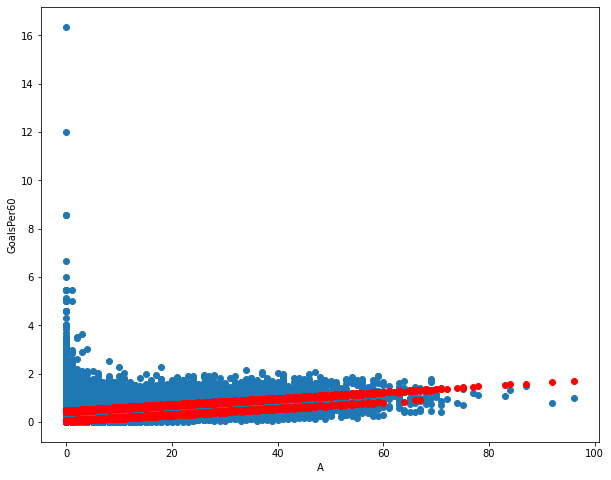

In [69]:
# Visualize the model's predictions when comparing Assists and Goals
plt.subplots(figsize=(10, 8))
plt.scatter(df['A'], df['GoalsPer60'] )
plt.scatter(df['A'], y_pred, color='red')
plt.xlabel('A')
plt.ylabel('GoalsPer60')
plt.show()

In [70]:
# We want to use regularization on the model
# Let's start with Ridge Regression

# We will use a grid search here to find the best alpha that maximizes the r2 value
parameters = {
    'alpha':range(1, 51)
}

ridge = Ridge()
grid = GridSearchCV(ridge, param_grid = parameters,
                    scoring = 'r2')

grid.fit(X_train, y_train)
print(f'R^2: {grid.best_score_:.3f}')
grid.best_params_

R^2: 0.287


{'alpha': 4}

In [71]:
# Look at how the Ridge model generalizes to the test data
y_pred = grid.predict(X_scale)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')

MSE:  0.186
RMSE: 0.432
R^2:  0.289


In [88]:
# Create model
tf.keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(
        25, activation='relu',
        input_shape=X_train.shape[1:]
    ),
    keras.layers.Dense(1)
])

opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mse', optimizer=opt)

model.save('mlp_regression_initial.h5')

y = df['GoalsPer60'] 
X = df[['A', 'HIT', 'AgeCategorical', 'FO%', 'PosBinary']]

# Split data into training and testing sets
(X_train_full, X_test, 
 y_train_full, y_test) = train_test_split(X, y, test_size=0.2,
                                          random_state=403)

# Split training data into training and validation subsets
(X_train, X_valid, 
 y_train, y_valid) = train_test_split(X_train_full, y_train_full,
                                      test_size=0.2,
                                      random_state=403)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

checkpoint_cb = keras.callbacks.ModelCheckpoint('mlp_regression_best.h5',
                                                save_best_only=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb],
                    verbose=0)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')

RMSE: 0.393
R2:   0.303

